In [1]:
from gurobipy import *
import numpy as np
import pandas as pd

In [2]:
#Warehouse
hrs=3.5
ot_hrs=3
employees=10
area=5

M=employees
N=area

area_max=np.array([6, 1, 1, 5, 5])
area_max_ot=np.array([6, 2, 2, 6, 5])

#Employee
cost=np.array([13.63, 11.9, 10.21, 14.1, 12.5, 10.9, 11.4, 12.8, 11.1, 10.2 ])
CS=1000

productivity = np.array([[35, 20,  4,  5, 25],
                         [31, 18,  0,  6, 25],
                         [27,  0,  0,  0, 33],
                         [26, 17, 10, 10, 31],
                         [22, 22, 10,  6, 18],
                         [20,  0,  0, 10, 31],
                         [20, 16,  9,  9, 38],
                         [21, 17,  8,  4, 38],
                         [22, 16, 11, 11, 15],
                         [25, 15, 8, 8, 25]])

 

productivity_ot = np.array([[32, 22,  0,  5, 25],
                            [0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0],
                            [25, 23.5, 8,  7, 22],
                            [20,  0,  0, 11, 32],
                            [15, 16,  12,  11, 38],
                            [0, 0, 0, 0, 0],
                            [0, 16, 11, 12.5, 18],
                            [0, 0, 0, 0, 0]])


attendance_morning=np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
attendance_afternoon=np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

ot_willing=np.array([1, 0, 0, 0, 1, 0, 1, 0, 1, 0])

employee_ot=np.zeros(M)



In [3]:
# Productivity Improvement Scenario

#focus_area = 5
#productivity_boost = 0.1
#productivity[:,focus_area-1:focus_area] = productivity[:,focus_area-1:focus_area] *(1+productivity_boost)
#productivity_ot[:,focus_area-1:focus_area] = productivity_ot[:,focus_area-1:focus_area] *(1+productivity_boost)

In [4]:
#productivity = np.array([[35, 20,  4,  5, 25],
#                         [31, 18,  4,  6, 25],
#                         [27, 16,  4,  4, 33],
#                         [26, 17, 10, 10, 31],
#                         [22, 22, 10,  6, 18],
#                         [20, 16,  4, 10, 31],
#                         [20, 16,  9,  9, 38],
#                         [21, 17,  8,  4, 38],
#                         [22, 16, 11, 11, 15],
#                         [25, 15, 8, 8, 25]])
#
#productivity_ot = np.array([[32, 22,  8,  5, 25],
#                            [0, 0, 0, 0, 0],
#                            [0, 0, 0, 0, 0],
#                            [0, 0, 0, 0, 0],
#                            [25, 23.5, 8,  7, 22],
#                            [20,  16,  8, 11, 32],
#                            [15, 16,  12,  11, 38],
#                            [0, 0, 0, 0, 0],
#                            [15, 16, 11, 12.5, 18],
#                            [0, 0, 0, 0, 0]])

In [5]:
def generatedemand(seed, size, multiplier = 1):
    # seed
    np.random.seed(seed)
   
    # demand in area 1 to 4
    a1 = np.round(np.random.normal(410, 20, size) * multiplier)
    a2 = np.round(95 +np.random.chisquare(10,size)* 1.5 * multiplier)
    a3 = np.round(np.random.normal(60, 6, size) * multiplier)
    a4 = np.round(np.random.chisquare(80, size)*2.4 - 15 *multiplier)
   
    # total for all the area
    a5 = np.round(a1 + a2 + a3 + a4)
   
    # demand
    demand = [a1[0], a2[0], a3[0], a4[0], a5[0]]
    
   
    return demand

In [6]:
def outbound_model():

    m = Model("Outbound_Assignment")

        # Creat variables
        #Normal hours assignment for first half day
    y = m.addVars(M, N, vtype = GRB.INTEGER)
        #Normal hours assignment for second half day
    z = m.addVars(M, N, vtype = GRB.INTEGER)
        #OT hours assignment
    x = m.addVars(M, N, vtype = GRB.INTEGER)
        #Slack headcount
    s = m.addVars(N)

        # Set objective
    m.setObjective( quicksum(1.5*cost[i]*x[i,j]*ot_hrs for i in range(M) for j in range(N)) + 
                       quicksum(CS*s[j] for j in range(N)), GRB.MINIMIZE)


        #Add employee asssignment constraint
    m.addConstrs(( quicksum(y[i,j] for j in range(N)) <= 1 for i in range(M) ),'Employee_Assignment_morning')
    m.addConstrs(( quicksum(z[i,j] for j in range(N)) <= 1 for i in range(M) ),'Employee_Assignment_afternoon')
    m.addConstrs(( quicksum(x[i,j] for j in range(N)) <= 1 for i in range(M) ),'Employee_Assignment_OT')

    m.addConstrs(( quicksum(x[i,j] for j in range(N)) <= ot_willing[i] for i in range(M) ),'Employee_OT_willing')

    m.addConstrs(( quicksum(y[i,j] for j in range(N)) <= attendance_morning[i] for i in range(M) ),'Attendance_moring')
    m.addConstrs(( quicksum(z[i,j] for j in range(N)) <= attendance_afternoon[i] for i in range(M) ),'Attendance_afternoon')
    m.addConstrs(( quicksum(x[i,j] for j in range(N)) <= attendance_afternoon[i] for i in range(M) ),'Attendance_OT')

    m.addConstrs(( quicksum(x[i,j] for j in range(N)) <= max_ot[i] for i in range(M) ),'Max_OT')

        # Add area demand constraints: 
    m.addConstrs(( (quicksum(productivity[i,j]*y[i,j]*hrs for i in range(M) ) + quicksum(productivity[i,j]*z[i,j]*hrs for i in range(M) ) +
                        quicksum(productivity_ot[i,j]*x[i,j]*ot_hrs for i in range(M) ) +
                        s[j] )>= demand[j] for j in range(N-1) ), "Demand_Area")

    m.addConstr(( (quicksum(productivity[i,j]*y[i,j]*hrs for i in range(M) for j in range(N-1)) + quicksum(productivity[i,j]*z[i,j]*hrs for i in range(M) for j in range(N-1)) 
                        + quicksum(productivity_ot[i,j]*x[i,j]*ot_hrs for i in range(M) for j in range(N-1)) )<= 
                        (quicksum(productivity[i,N-1]*y[i,N-1]*hrs for i in range(M) ) + 
                        quicksum(productivity_ot[i,N-1]*x[i,N-1]*ot_hrs for i in range(M)) +quicksum(productivity[i,N-1]*z[i,N-1]*hrs for i in range(M) )) ), "Packaging_requirement")


    m.addConstr(( quicksum(productivity_ot[i,j]*x[i,j]*ot_hrs for i in range(M) for j in range(N-1))+ quicksum(productivity[i,j]*z[i,j]*hrs for i in range(M) for j in range(N-1)) <= 
                        quicksum(productivity_ot[i,N-1]*x[i,N-1]*ot_hrs for i in range(M))+quicksum(productivity[i,N-1]*z[i,N-1]*hrs for i in range(M))  ), "Packaging_aftenoon_and_OT")

    m.addConstr(( quicksum(productivity_ot[i,j]*x[i,j]*ot_hrs for i in range(M) for j in range(N-1)) <= 
                        quicksum(productivity_ot[i,N-1]*x[i,N-1]*ot_hrs for i in range(M))  ), "Packaging_OT_requirement")

    m.addConstrs(( quicksum(y[i,j] for i in range(M)) <= area_max[j] for j in range(N) ),'Area_max_employee_Normal')
    m.addConstrs(( quicksum(z[i,j] for i in range(M)) <= area_max[j] for j in range(N) ),'Area_max_employee_Normal')
    m.addConstrs(( quicksum(x[i,j] for i in range(M)) <= area_max_ot[j] for j in range(N) ),'Area_max_employee_OT')




    #Supressing the optimization output
    m.setParam( 'OutputFlag', False )
    
    # Solving the model
    #m.optimize()

    return m

In [7]:
def morning_assignment(m):
    v=m.getVars()
    v = np.reshape(v[0:M*N], (M,N))

    print('Normal Morning Assingment:\n')
    for i in range(M):
        for j in range(N):
            print( round(v[i,j].x), end =" ")
        print("\n")
        
def evening_assignment(m):
    v=m.getVars()
    v = np.reshape(v[M*N:2*M*N], (M,N))

    print('Normal Afternoon Assingment:\n')
    for i in range(M):
        for j in range(N):
            print( round(v[i,j].x), end =" ")
        print("\n")
    
def ot(m):
    v=m.getVars()
    v = np.reshape(v[2*M*N:3*M*N], (M,N))
        
    print('OT Assingment:\n')
    for i in range(M):
        for j in range(N):
            print( round(v[i,j].x), end =" ")
        print("\n") 
    


def overtime_cost(m):
    v=m.getVars()
    v = np.reshape(v[2*M*N:3*M*N], (M,N))
    
    tmp = 0
    hr = 0
    
    for i in range(M):
        emp_hr = 0
        for j in range(N):
            tmp = tmp + cost[i]*round(v[i,j].x)*ot_hrs*1.5
            emp_hr = emp_hr + round(v[i,j].x)*ot_hrs
        employee_ot[i] = employee_ot[i] + emp_hr
        hr = hr + emp_hr
    #print(tmp)
    return tmp, hr


def capacity(m):
    v=m.getVars()

    v = v[3*M*N:]
    backlog=[]
    
    for j in range(N):
            #print( v[j].x, end =" ")
            backlog.append(round(v[j].x) )
            #print("\n")
            
    #print('Total capacity issue:\n',sum(backlog))
    
    backlog[4] = backlog[4] + sum(backlog[0:4])
    
    print('Area capacity issue:\n', backlog )
    
    return backlog
            
def daily(m):
    #morning_assignment(m)
    #evening_assignment(m)
    #ot(m)
    day_ot_cost = overtime_cost(m)
    capacity(m)
    
    return day_ot_cost
            

In [8]:
backlog_month = []
OT_cost_month = []
OT_hr_month = []
backlog = []
demand_month = []


for i in range(30):
    print('Day demand:\n',generatedemand(i,1,1))
    if i==0:
        demand = generatedemand(i,1,1)
    else:
        demand = generatedemand(i,1,1) + np.array(backlog)
    print('Total Demand:',demand)
    
    demand_month.append(demand)
    
    max_ot=np.maximum((np.ones(employees)*72)-employee_ot-(np.ones(employees)*3)+1, np.zeros(employees))
    
    # setup the model
    m = outbound_model()

    # Solving the model
    m.optimize()
    
    print('Objective Cost:', m.objVal)
    
    # Find daily OT cost
    print('Daily OT Cost:\n')
    
    tmp, hr =  overtime_cost(m)       
    
    print(tmp)
    
    #Append to monthly OT Cost and hr
    OT_cost_month.append(tmp)
    OT_hr_month.append(hr)
    
    print('Employee OT:\n', employee_ot)
    
    # Find daily slack in area
    backlog = capacity(m)
    
    #Append to monthly slack
    backlog_month.append(backlog)
    
    print('-'*25, i, '-'*25)


Day demand:
 [445.0, 112.0, 46.0, 219.0, 822.0]
Total Demand: [445.0, 112.0, 46.0, 219.0, 822.0]
Using license file c:\gurobi903\gurobi.lic
Academic license - for non-commercial use only
Objective Cost: 157.5
Daily OT Cost:

157.5
Employee OT:
 [0. 0. 0. 0. 3. 0. 3. 0. 3. 0.]
Area capacity issue:
 [0, 0, 0, 0, 0]
------------------------- 0 -------------------------
Day demand:
 [442.0, 105.0, 55.0, 162.0, 764.0]
Total Demand: [442. 105.  55. 162. 764.]
Objective Cost: 101.25
Daily OT Cost:

101.25
Employee OT:
 [0. 0. 0. 0. 3. 0. 6. 0. 6. 0.]
Area capacity issue:
 [0, 0, 0, 0, 0]
------------------------- 1 -------------------------
Day demand:
 [402.0, 109.0, 48.0, 131.0, 690.0]
Total Demand: [402. 109.  48. 131. 690.]
Objective Cost: 0.0
Daily OT Cost:

0.0
Employee OT:
 [0. 0. 0. 0. 3. 0. 6. 0. 6. 0.]
Area capacity issue:
 [0, 0, 0, 0, 0]
------------------------- 2 -------------------------
Day demand:
 [446.0, 112.0, 66.0, 176.0, 800.0]
Total Demand: [446. 112.  66. 176. 800.]
Ob

In [9]:
print('Monthly OT Cost:\n',sum(OT_cost_month) )
print('Monthly OT hours:\n',sum(OT_hr_month) )
print('Avg Daily OT Cost:\n',round(sum(OT_cost_month)/len(OT_cost_month),2 ) )
print('Avg Daily OT hours:\n',round(sum(OT_hr_month)/len(OT_hr_month),2 ))


Monthly OT Cost:
 3590.595
Monthly OT hours:
 204
Avg Daily OT Cost:
 119.69
Avg Daily OT hours:
 6.8


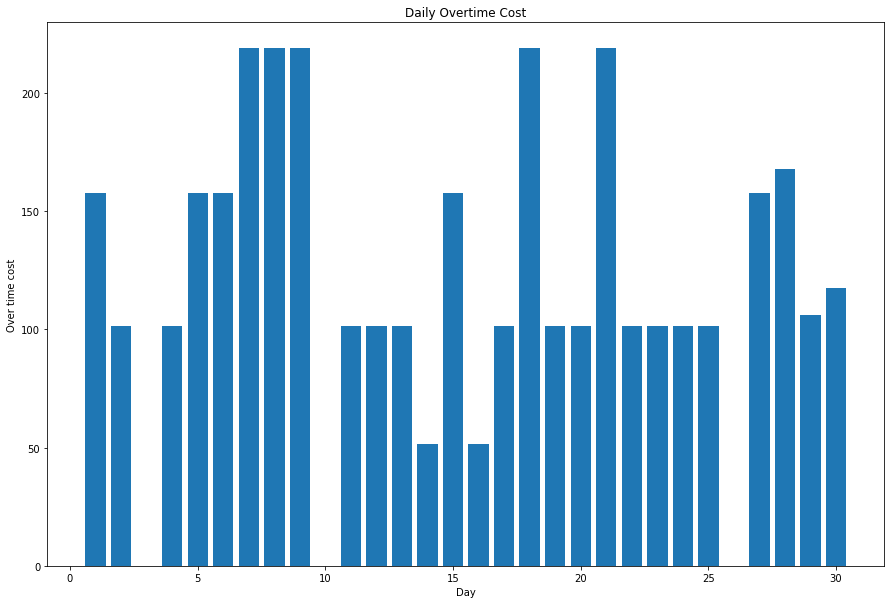

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.bar(x= list(range(1,31)), height = OT_cost_month)
plt.title('Daily Overtime Cost')
plt.ylabel('Over time cost')
plt.xlabel('Day')
plt.savefig('Daily Overtime Cost')
plt.show()

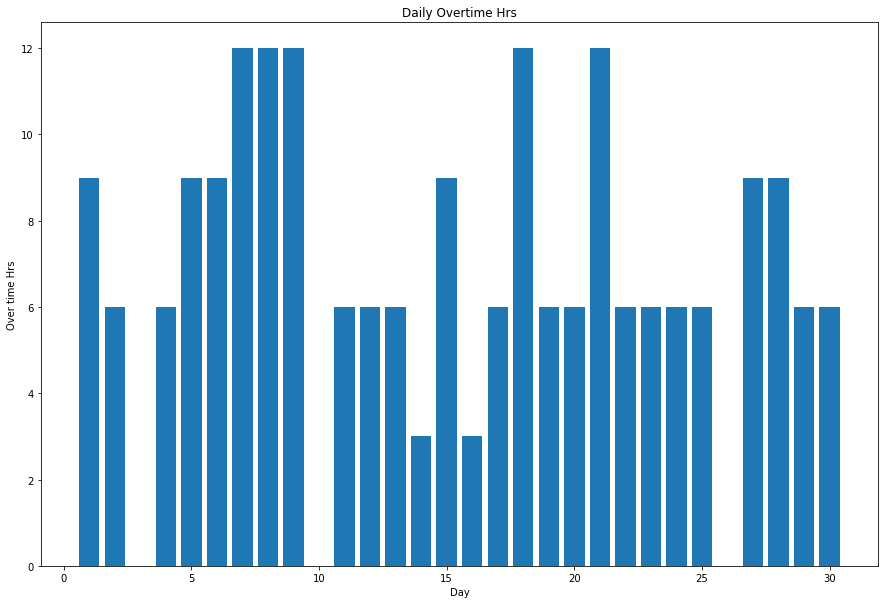

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.bar(x= list(range(1,31)), height = OT_hr_month)
plt.title('Daily Overtime Hrs')
plt.ylabel('Over time Hrs')
plt.xlabel('Day')
plt.savefig('Daily Overtime Hrs')
plt.show()

In [12]:
backlog_month=pd.DataFrame(backlog_month, columns=['Area1', 'Area2', 'Area3', 'Area4', 'Area5'])

backlog_month['Total'] = backlog_month['Area1'] + backlog_month['Area2'] + backlog_month['Area3'] + backlog_month['Area4']

demand_month = pd.DataFrame(demand_month, columns=['Area1', 'Area2', 'Area3', 'Area4', 'Area5'])

demand_month['Total'] = demand_month['Area5']

capacity_month = demand_month - backlog_month

In [13]:
print('Monthly Backlog:\n',backlog_month['Total'].sum() )

Monthly Backlog:
 129


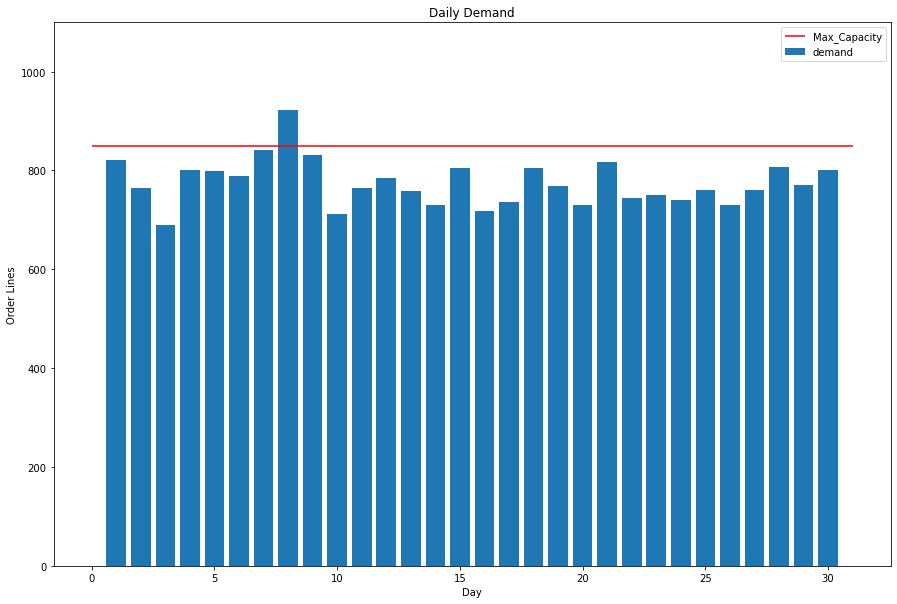

In [14]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15,10))
plt.bar(x= list(range(1,31)), height = demand_month['Total'], label='demand')
plt.hlines(y = max(capacity_month['Total']), xmin = 0, xmax = 31, colors='r', linestyles='solid', label='Max_Capacity')
plt.ylim([0,1100])
plt.title('Daily Demand')
plt.ylabel('Order Lines')
plt.xlabel('Day')
plt.legend()
plt.savefig('Daily Demand')
plt.show()

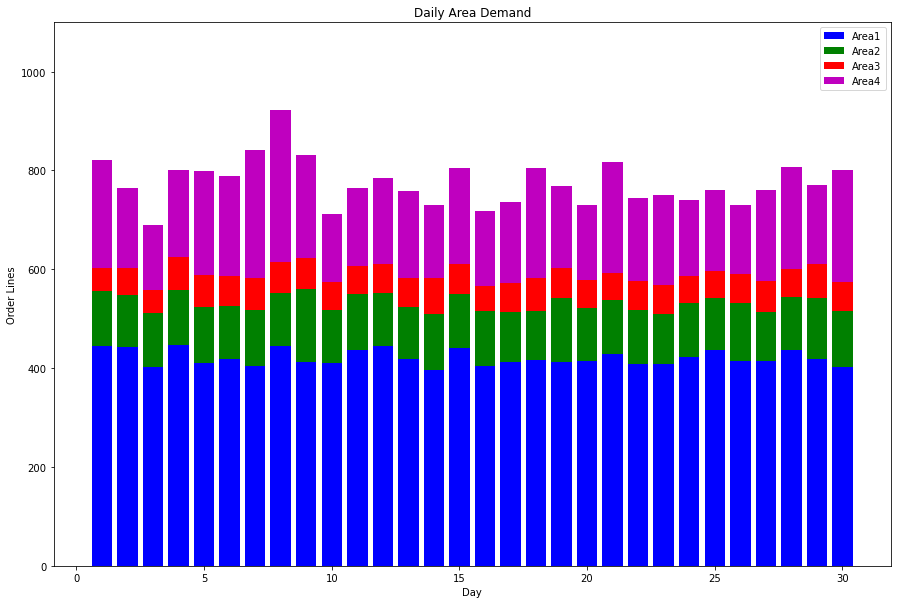

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.bar(x= list(range(1,31)), height = demand_month['Area1'], label='Area1', color = 'b')
plt.bar(x= list(range(1,31)), height = demand_month['Area2'], bottom = demand_month['Area1'] , label='Area2', color = 'g')
plt.bar(x= list(range(1,31)), height = demand_month['Area3'], bottom = demand_month['Area1'] + demand_month['Area2'], label='Area3', color = 'r')
plt.bar(x= list(range(1,31)), height = demand_month['Area4'], bottom = demand_month['Area1'] + demand_month['Area2']+ demand_month['Area3'], label='Area4', color = 'm')


plt.ylim([0,1100])
plt.ylabel('Order Lines')
plt.title('Daily Area Demand')
plt.xlabel('Day')
plt.legend()
plt.savefig('Daily Area Demand')
plt.show()

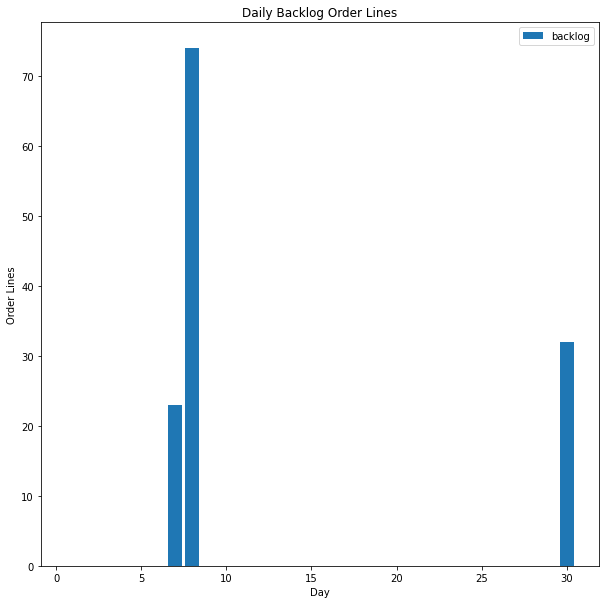

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

plt.bar(x= list(range(1,31)), height = backlog_month['Total'], label='backlog')

plt.ylabel('Order Lines')
plt.title('Daily Backlog Order Lines')
plt.xlabel('Day')
plt.legend()
plt.savefig('Daily Backlog Order Lines')
plt.show()

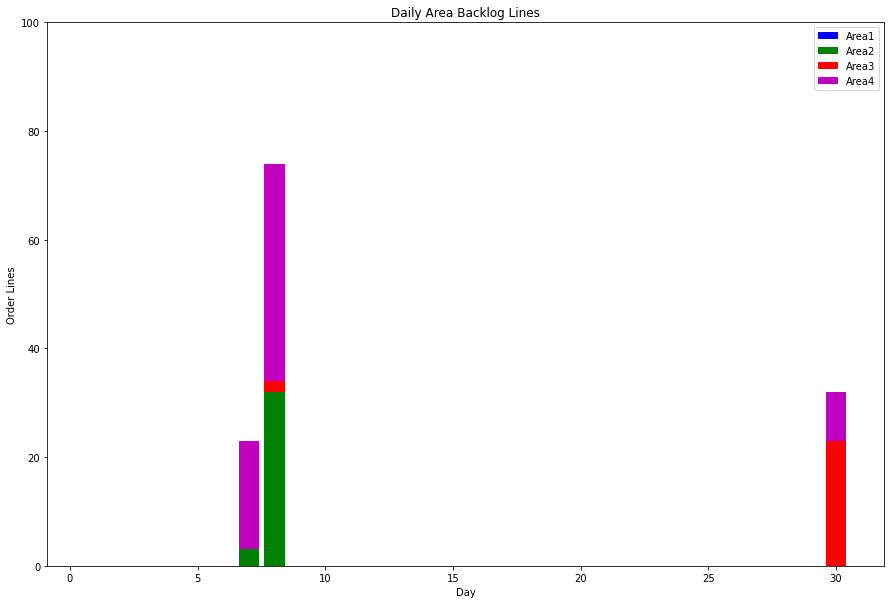

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.bar(x= list(range(1,31)), height = backlog_month['Area1'], label='Area1', color = 'b')
plt.bar(x= list(range(1,31)), height = backlog_month['Area2'], bottom = backlog_month['Area1'] , label='Area2', color = 'g')
plt.bar(x= list(range(1,31)), height = backlog_month['Area3'], bottom = backlog_month['Area1'] + backlog_month['Area2'], label='Area3', color = 'r')
plt.bar(x= list(range(1,31)), height = backlog_month['Area4'], bottom = backlog_month['Area1'] + backlog_month['Area2']+ backlog_month['Area3'], label='Area4', color = 'm')


plt.ylim([0,100])
plt.ylabel('Order Lines')
plt.title('Daily Area Backlog Lines')
plt.xlabel('Day')
plt.legend()
plt.savefig('Daily Area Backlog Lines')
plt.show()

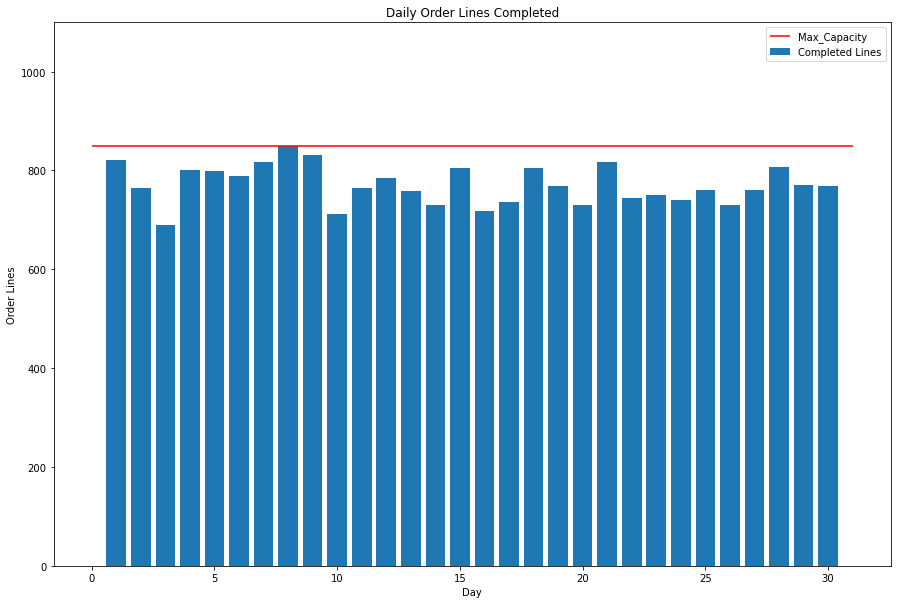

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

plt.bar(x= list(range(1,31)), height = capacity_month['Total'], label='Completed Lines')
plt.hlines(y = max(capacity_month['Total']), xmin = 0, xmax = 31, colors='r', linestyles='solid', label='Max_Capacity')
plt.ylim([0,1100])
plt.ylabel('Order Lines')
plt.title('Daily Order Lines Completed')
plt.xlabel('Day')
plt.legend()
plt.savefig('Daily Order Lines Completed')
plt.show()

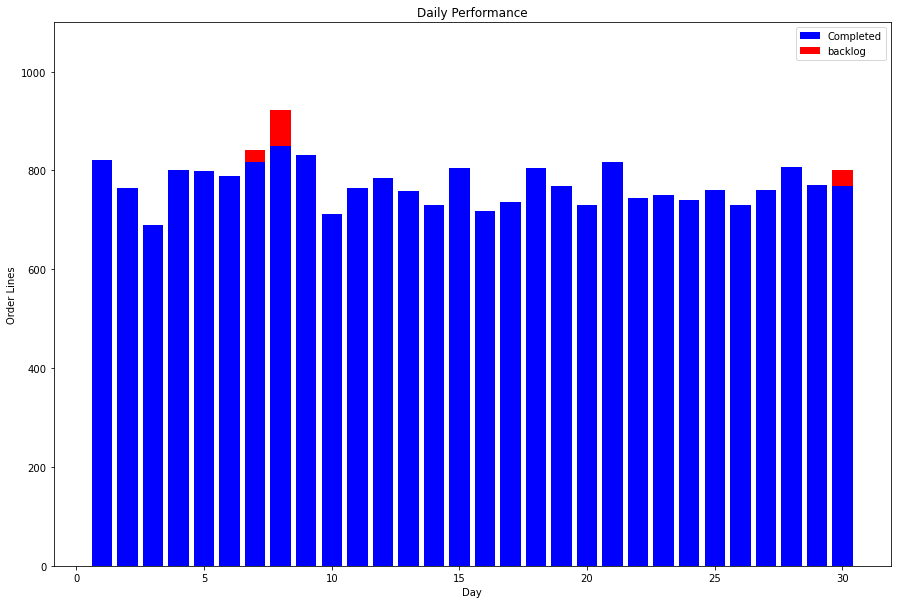

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
p1 = plt.bar(x= list(range(1,31)), height = capacity_month['Total'], label='Completed', color = 'b')
p2 = plt.bar(x= list(range(1,31)), height = backlog_month['Total'], bottom =capacity_month['Total'], label='backlog', color = 'r')

plt.ylim([0,1100])
plt.ylabel('Order Lines')
plt.title('Daily Performance')
plt.xlabel('Day')
plt.legend()
plt.savefig('Daily Performance')
plt.show()

In [20]:
#demand=pd.DataFrame(demand_month)
#demand.to_csv('monthly_demand.csv')

In [22]:
traditional = pd.read_csv('traditional.csv')
traditional['Area 5'] = traditional['Area 5'] - traditional['Area 4']
traditional.head()

,Area 4,Area 5,Total (Cost),Total (Hour)
0,0.0,4.0,218.835,12
1,0.0,0.0,101.250,6
2,0.0,0.0,0.000,0
3,0.0,0.0,101.250,6
4,0.0,0.0,162.585,9


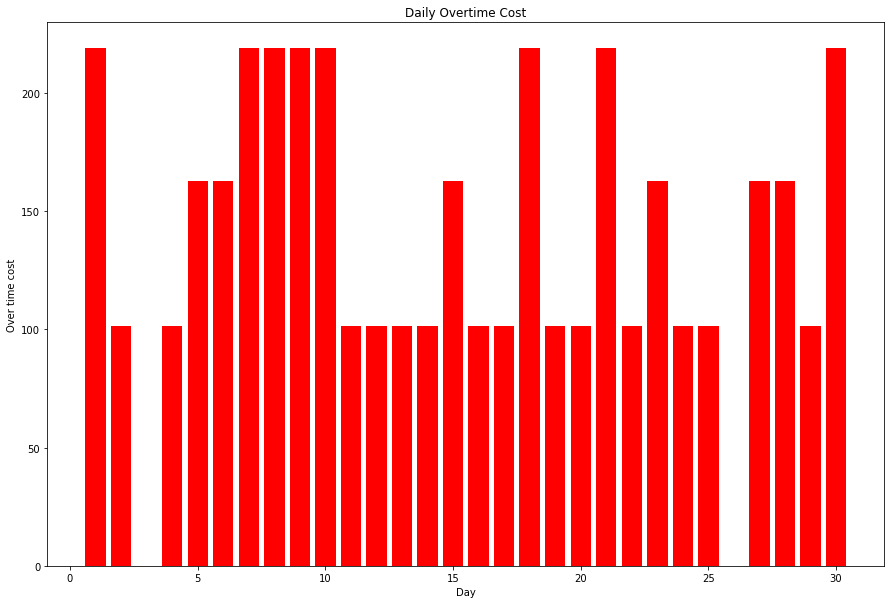

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.bar(x= list(range(1,31)), height = traditional['Total (Cost)'], color = 'r')
plt.title('Daily Overtime Cost')
plt.ylabel('Over time cost')
plt.xlabel('Day')
plt.savefig('Daily traditional_Overtime Cost')
plt.show()

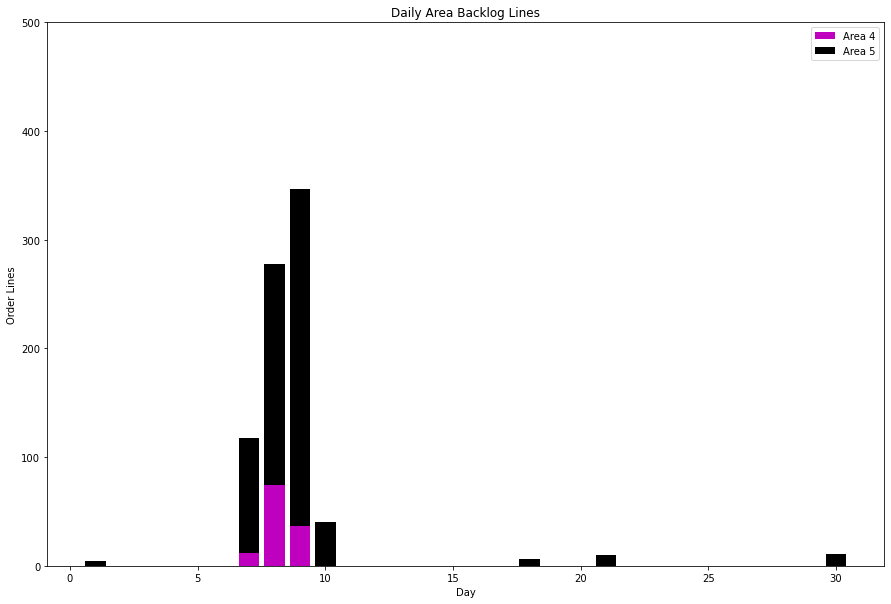

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.bar(x= list(range(1,31)), height = traditional['Area 4'], label='Area 4', color = 'm')
plt.bar(x= list(range(1,31)), height = traditional['Area 5'], bottom = traditional['Area 4'] , label='Area 5', color = 'k')


plt.ylim([0,500])
plt.ylabel('Order Lines')
plt.title('Daily Area Backlog Lines')
plt.xlabel('Day')
plt.legend()
plt.savefig('Daily Area Backlog Lines_traditional')
plt.show()